# Defining functions

In [1]:
import requests
import urllib
import time
import re
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import time
import os.path
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#helpers

def check_film_genre(film):
    '''
    This function checks if it is a featured movie or not. If not,
    it returns False, else True
    '''
    if film.text.find('TV Series')!=-1 or film.text.find('Short')!=-1\
    or film.text.find('Video Game')!=-1 or film.text.find('Video short')!=-1\
    or film.text.find('Video')!=-1 or film.text.find('TV Movie')!=-1\
    or film.text.find('TV Mini-Series')!=-1 or film.text.find('TV Series short')!=-1\
    or film.text.find('TV Special')!=-1 or film.text.find('voice')!=-1:
        return False
    else:
        return True
    
def get_page_soup(url):
    '''
    Function returns soup for a given url argument
    '''
    headers = {'Accept-Language': 'en',
          'X-FORWARDED-FOR': '2.21.184.0'}

    response = requests.get(url, headers = headers)
    soup = BeautifulSoup(response.text, features="html.parser")
    return soup

In [3]:
#main functions

def get_actors_by_movie_soup(cast_page_soup, num_of_actors_limit=None):
    url = 'https://www.imdb.com/'
    try:
        cast = cast_page_soup.find('table', 
                 attrs={'class': 'cast_list'})
        actors_photos = cast.find_all('td',
                        attrs={'class': 'primary_photo'})
        names = []
        for photo in actors_photos:
            name = photo.find_next('td').find('a')
            names.append((name.text.replace("\n", "")\
                          .strip(), urllib.parse.urljoin(url, name['href'], '/fullcredits')))
    except:
        names = []
    if not num_of_actors_limit:
        return names
    else:
        return names[:num_of_actors_limit]
    
    
def get_movies_by_actor_soup(actor_page_soup, num_of_movies_limit=None):
    url = 'https://www.imdb.com/'
    try:
        films = actor_page_soup.find('div', attrs={'class':'filmo-category-section'})\
        .find_all('div', attrs={'class':'filmo-row'})
        films_list = []
        for film in films:
            if not film.find('a', attrs={'class': 'in_production'}) and check_film_genre(film):
                films_list.append((film.find('a').text, urllib.parse.urljoin(url, film.find('a')['href'])))
    except:
        films_list = []
        

    if not num_of_movies_limit:
        return films_list
    else:
        return films_list[:num_of_movies_limit]
    
    
    
def get_movie_distance(actor_start_url, actor_end_url, num_of_actors_limit=None, num_of_movies_limit=None):
    current_distance = 1
    actors_distances = {}
    actors_dict = {}
    seen_actors = set()
    
    actors_dict = get_actor_list_of_actors(actor_start_url, actor_end_url, num_of_actors_limit, num_of_movies_limit)

    if (actor_end_url in actors_dict.keys())\
        or ('https://www.imdb.com'+urlparse(actor_end_url).path in actors_dict.keys()):
        return current_distance
    else:
        while current_distance != 3:
            for name in actors_dict.values():
                actors_distances[name] = current_distance
            current_distance += 1
        
            temp_dict = {}
            for url, name in actors_dict.items():
                if (actors_distances[name] == current_distance - 1) and (name not in seen_actors):
                    seen_actors.add(name)
                    temp_dict = temp_dict | get_actor_list_of_actors(url, actor_end_url, num_of_actors_limit, num_of_movies_limit)
                    if (actor_end_url in temp_dict.keys())\
                    or ('https://www.imdb.com'+urlparse(actor_end_url).path in temp_dict.keys()):
                        return current_distance
            
            actors_dict = temp_dict
        else:
            return float('inf')
            

In [4]:
#helper function that returns dict of actors for the passed actor url
def get_actor_list_of_actors(actor_url, actor_end, num_of_actors_limit=None, num_of_movies_limit=None):
    
    #check if we scraped info about the actor earlier
    #go to file actors.txt if it exists and scrape list of movies
    #for selected actor
    if os.path.exists('./actors.txt'):
        with open('actors.txt', 'r') as f:
            actors = json.load(f)
    else:
        actors = {}
    
    if actor_url in actors.keys():
        actor_movies = actors[actor_url]
    else:
        actor_movies = get_movies_by_actor_soup(get_page_soup(actor_url), num_of_movies_limit)
        #add actors movie list into file
        actors[actor_url] = actor_movies
        with open('actors.txt', 'w') as file:
            json.dump(actors, file)
    
    actors_dict = {}
    for movie in actor_movies:
        movie_url = movie[1] + 'fullcredits'
        
       
        
        #check if we scraped info about movie before 
        if os.path.exists('./movies.txt'):
            with open('movies.txt', 'r') as f:
                movies = json.load(f)
        else:
            movies = {}
        
        if movie_url in movies.keys():
            movie_actors = movies[movie_url]
        else:
            movie_soup = get_page_soup(movie_url)
            movie_actors = get_actors_by_movie_soup(movie_soup, num_of_actors_limit)
            movies[movie_url] = movie_actors
            #add movie info into file
            with open('movies.txt', 'w') as file:
                json.dump(movies, file)
                
                
        for actor in movie_actors:
            actors_dict[actor[1]] = actor[0]
        if actor_end in actors_dict.keys():
            return actors_dict
            
    return actors_dict

# Scraping data

Dwayne Johnson https://www.imdb.com/name/nm0425005/

Chris Hemsworth https://www.imdb.com/name/nm1165110/

Robert Downey Jr. https://www.imdb.com/name/nm0000375/

Akshay Kumar https://www.imdb.com/name/nm0474774/

Jackie Chan https://www.imdb.com/name/nm0000329/

Bradley Cooper https://www.imdb.com/name/nm0177896/

Adam Sandler https://www.imdb.com/name/nm0001191/

Scarlett Johansson https://www.imdb.com/name/nm0424060/

Sofia Vergara https://www.imdb.com/name/nm0005527/

Chris Evans https://www.imdb.com/name/nm0262635/

In [5]:
#creating lists of actors urls and nodes for graphs

actors_urls = ['https://www.imdb.com/name/nm0425005/', 'https://www.imdb.com/name/nm1165110/',
                'https://www.imdb.com/name/nm0000375/', 'https://www.imdb.com/name/nm0474774/', 
                'https://www.imdb.com/name/nm0000329/', 'https://www.imdb.com/name/nm0177896/',
                'https://www.imdb.com/name/nm0001191/', 'https://www.imdb.com/name/nm0424060/',
                'https://www.imdb.com/name/nm0005527/', 'https://www.imdb.com/name/nm0262635/']

nodes = ['Dwayne Johnson', 'Chris Hemsworth', 'Robert Downey Jr.', 'Akshay Kumar',
        'Jackie Chan', 'Bradley Cooper', 'Adam Sandler', 'Scarlett Johansson', 'Sofia Vergara', 'Chris Evans']


In [6]:
#create a dictionary with actors names and their urls,
#where key is name and value is url
names_and_urls = {}
for i in range(10):
    names_and_urls[nodes[i]] = actors_urls[i]

In [7]:
names_and_urls

{'Dwayne Johnson': 'https://www.imdb.com/name/nm0425005/',
 'Chris Hemsworth': 'https://www.imdb.com/name/nm1165110/',
 'Robert Downey Jr.': 'https://www.imdb.com/name/nm0000375/',
 'Akshay Kumar': 'https://www.imdb.com/name/nm0474774/',
 'Jackie Chan': 'https://www.imdb.com/name/nm0000329/',
 'Bradley Cooper': 'https://www.imdb.com/name/nm0177896/',
 'Adam Sandler': 'https://www.imdb.com/name/nm0001191/',
 'Scarlett Johansson': 'https://www.imdb.com/name/nm0424060/',
 'Sofia Vergara': 'https://www.imdb.com/name/nm0005527/',
 'Chris Evans': 'https://www.imdb.com/name/nm0262635/'}

In [8]:
#create list of pairs of urls (edges) that we need to find distances for
edges = []
for i in range(len(nodes) + 1):
    for j in range(i + 1, len(nodes)):
            edges.append((nodes[i], nodes[j]))
        
len(edges)

45

In [9]:
#create cashe with information about distances
cashe = {}

In [10]:
#scrape the distances as a dictionary, where key is a tuple of urls and value is distance integer
def scrape_distances():
    distances = {}
    for i in range(len(actors_urls)+1):
        for j in range(i+1, len(actors_urls)):
            if (actors_urls[i], actors_urls[j]) in cashe.keys():
                distances[(actors_urls[i], actors_urls[j])] = cashe[(actors_urls[i], actors_urls[j])]
            else:
                distance = get_movie_distance(actors_urls[i], actors_urls[j], 5, 5)
                time.sleep(1)
                cashe[(actors_urls[i], actors_urls[j])] = distance
                distances[(actors_urls[i], actors_urls[j])] = distance
                
    return distances

In [11]:
distances = scrape_distances()

In [12]:
#create a dictionary where key is a tiple of names and value is a distance
#change infinite values to -1 for a better foramtting
distances_with_names = {}

for edge in edges:
    key = edge
    value = distances[(names_and_urls[edge[0]], names_and_urls[edge[1]])]
    
    if value == float('inf'):
        value = -1
                       
    distances_with_names[key] = value

In [13]:
distances_with_names 

{('Dwayne Johnson', 'Chris Hemsworth'): 2,
 ('Dwayne Johnson', 'Robert Downey Jr.'): 3,
 ('Dwayne Johnson', 'Akshay Kumar'): -1,
 ('Dwayne Johnson', 'Jackie Chan'): -1,
 ('Dwayne Johnson', 'Bradley Cooper'): 3,
 ('Dwayne Johnson', 'Adam Sandler'): 3,
 ('Dwayne Johnson', 'Scarlett Johansson'): 3,
 ('Dwayne Johnson', 'Sofia Vergara'): -1,
 ('Dwayne Johnson', 'Chris Evans'): 3,
 ('Chris Hemsworth', 'Robert Downey Jr.'): 3,
 ('Chris Hemsworth', 'Akshay Kumar'): 3,
 ('Chris Hemsworth', 'Jackie Chan'): 2,
 ('Chris Hemsworth', 'Bradley Cooper'): 3,
 ('Chris Hemsworth', 'Adam Sandler'): 3,
 ('Chris Hemsworth', 'Scarlett Johansson'): 2,
 ('Chris Hemsworth', 'Sofia Vergara'): -1,
 ('Chris Hemsworth', 'Chris Evans'): 3,
 ('Robert Downey Jr.', 'Akshay Kumar'): -1,
 ('Robert Downey Jr.', 'Jackie Chan'): 3,
 ('Robert Downey Jr.', 'Bradley Cooper'): 3,
 ('Robert Downey Jr.', 'Adam Sandler'): 3,
 ('Robert Downey Jr.', 'Scarlett Johansson'): 1,
 ('Robert Downey Jr.', 'Sofia Vergara'): 3,
 ('Robert Down

In [14]:
#collect data from distances_with_names to form correct dataframe
data = {}
for name in nodes:
    distance_list =[]
    for tup, distance in distances_with_names.items():
        if tup[0] == name:
            distance_list.append(distance)
     
    val_list = [0] * (nodes.index(name) + 1) + distance_list
    data[name] = val_list

In [15]:
data

{'Dwayne Johnson': [0, 2, 3, -1, -1, 3, 3, 3, -1, 3],
 'Chris Hemsworth': [0, 0, 3, 3, 2, 3, 3, 2, -1, 3],
 'Robert Downey Jr.': [0, 0, 0, -1, 3, 3, 3, 1, 3, 1],
 'Akshay Kumar': [0, 0, 0, 0, -1, -1, -1, -1, -1, -1],
 'Jackie Chan': [0, 0, 0, 0, 0, 3, 3, -1, 3, -1],
 'Bradley Cooper': [0, 0, 0, 0, 0, 0, 3, 3, 3, 3],
 'Adam Sandler': [0, 0, 0, 0, 0, 0, 0, 3, 3, 3],
 'Scarlett Johansson': [0, 0, 0, 0, 0, 0, 0, 0, -1, 1],
 'Sofia Vergara': [0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
 'Chris Evans': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [16]:
#create a dataframe where columns are 'from' and rows are 'to'
df = pd.DataFrame(data, index=nodes)

In [17]:
header = [['From']*10, nodes]
df.columns = header

In [18]:
df

From                                    \
                   Dwayne Johnson Chris Hemsworth Robert Downey Jr.   
Dwayne Johnson                  0               0                 0   
Chris Hemsworth                 2               0                 0   
Robert Downey Jr.               3               3                 0   
Akshay Kumar                   -1               3                -1   
Jackie Chan                    -1               2                 3   
Bradley Cooper                  3               3                 3   
Adam Sandler                    3               3                 3   
Scarlett Johansson              3               2                 1   
Sofia Vergara                  -1              -1                 3   
Chris Evans                     3               3                 1   

                                                                         \
                   Akshay Kumar Jackie Chan Bradley Cooper Adam Sandler   
Dwayne Johnson                0           0              0            0   
Chris Hemsworth               0           0              0            0   
Robert Downey Jr.             0           0              0            0   
Akshay Kumar                  0           0              0            0   
Jackie Chan                  -1           0              0            0   
Bradley Cooper               -1           3              0            0   
Adam Sandler                 -1           3              3            0   
Scarlett Johansson           -1          -1              3            3   
Sofia Vergara                -1           3              3            3   
Chris Evans                  -1          -1              3            3   

                                                                 
                   Scarlett Johansson Sofia Vergara Chris Evans  
Dwayne Johnson                      0             0           0  
Chris Hemsworth                     0             0           0  
Robert Downey Jr.                   0             0           0  
Akshay Kumar                        0             0           0  
Jackie Chan                         0             0           0  
Bradley Cooper                      0             0           0  
Adam Sandler                        0             0           0  
Scarlett Johansson                  0             0           0  
Sofia Vergara                      -1             0           0  
Chris Evans                         1             2           0

In [19]:
#save dataframe
df.to_csv('movie_distances.csv')

# Plotting the graphs

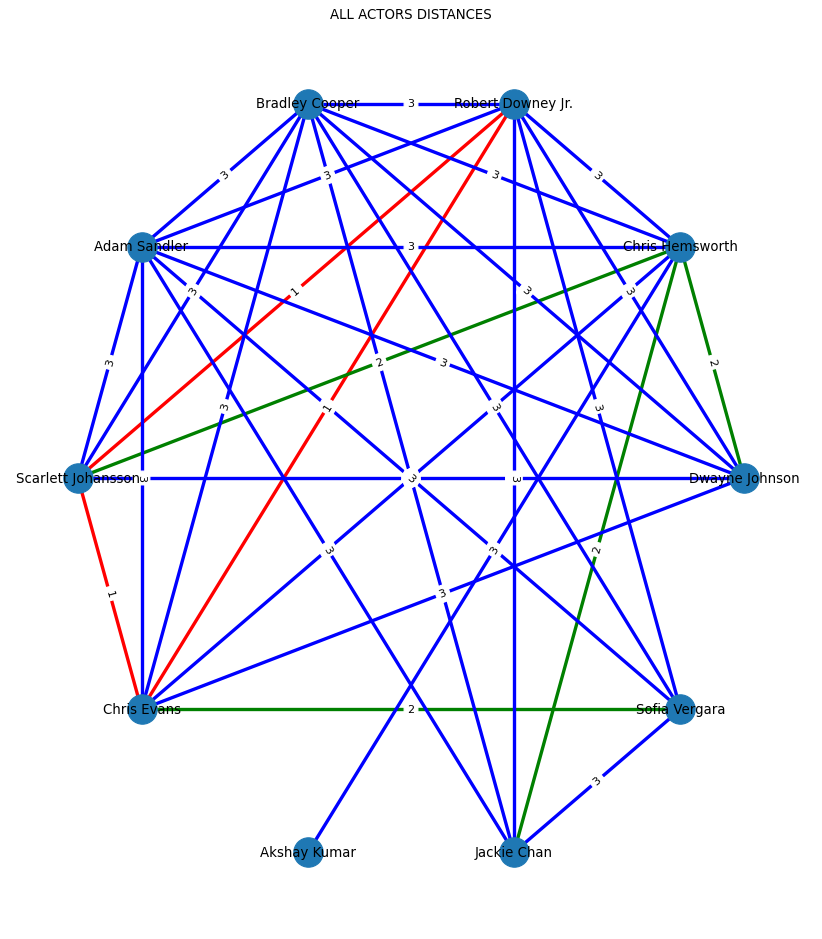

In [20]:
plt.figure(num=None, figsize=(13, 15), dpi=80)
plt.axis("off")
plt.title('ALL ACTORS DISTANCES')


G = nx.Graph()
for pair, distance in distances_with_names.items():
    if distance != -1:
        G.add_edge(pair[0], pair[1], weight=distance)
        
red = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] ==1]
green = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 2]
blue = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 3]
pos = nx.circular_layout(G)


nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, edgelist=red, width=3, edge_color="r")
nx.draw_networkx_edges(G, pos, edgelist=green, width=3, edge_color="g")
nx.draw_networkx_edges(G, pos, edgelist=blue, width=3,  edge_color="b")


nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)


plt.show()


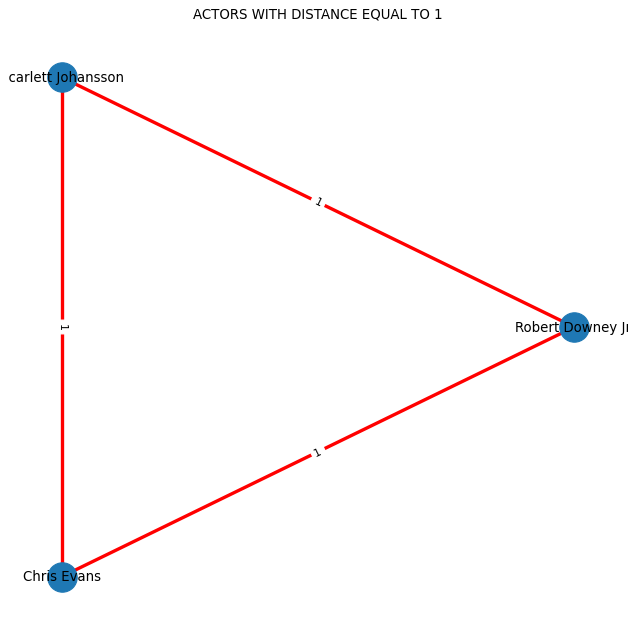

In [21]:
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.axis("off")
plt.title('ACTORS WITH DISTANCE EQUAL TO 1')


G = nx.Graph()
for pair, distance in distances_with_names.items():
    if distance == 1:
        G.add_edge(pair[0], pair[1], weight=distance)
        
red = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] ==1]
pos = nx.circular_layout(G)


nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, edgelist=red, width=3, edge_color="r")



nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)


plt.show()

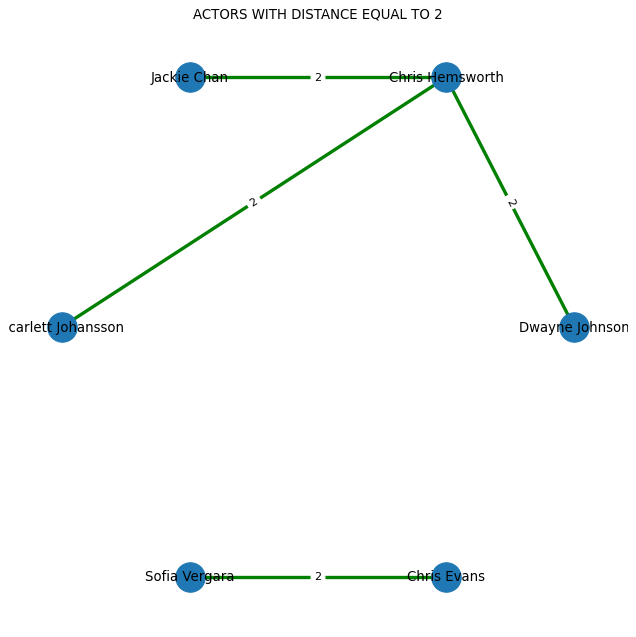

In [22]:
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.axis("off")
plt.title('ACTORS WITH DISTANCE EQUAL TO 2')


G = nx.Graph()
for pair, distance in distances_with_names.items():
    if distance == 2:
        G.add_edge(pair[0], pair[1], weight=distance)
        
green = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 2]
pos = nx.circular_layout(G)


nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, edgelist=green, width=3, edge_color="g")


nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)


plt.show()

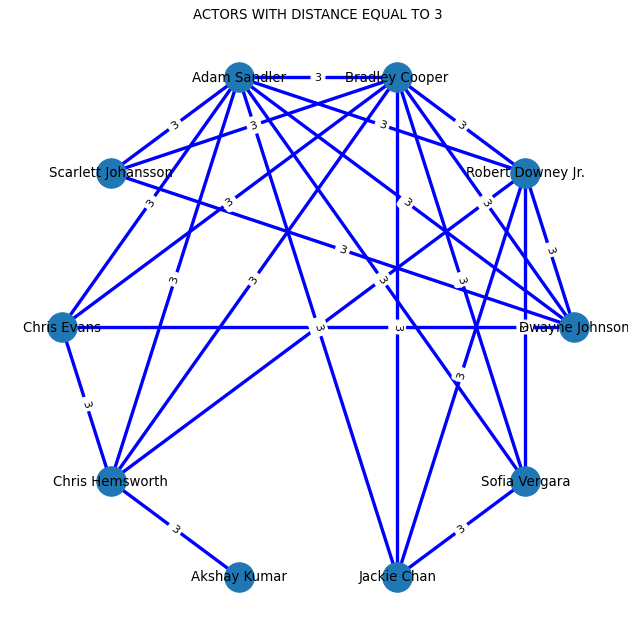

In [25]:
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.axis("off")
plt.title('ACTORS WITH DISTANCE EQUAL TO 3')


G = nx.Graph()
for pair, distance in distances_with_names.items():
    if distance == 3:
        G.add_edge(pair[0], pair[1], weight=distance)
        
blue = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 3]
pos = nx.circular_layout(G)


nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, edgelist=blue, width=3,  edge_color="b")


nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)


plt.show()


# Collect movie descriptions

In [72]:
#function takes a soup of actor and returns all film descriptions of this actor in one list
def get_movie_descriptions_by_actor_soup(actor_page_soup):
    movies_list = get_movies_by_actor_soup(actor_page_soup)
    movie_descriptions = []
    
    for movie in movies_list:
        movie_soup = get_page_soup(movie[1])
        try:
            description = movie_soup.find('span', attrs={'data-testid': 'plot-xl'}).text.replace('... Read all', '')
            movie_descriptions.append(description)
        except:
            continue
        time.sleep(1)
        
    return movie_descriptions
                                      

In [74]:
# creating description files for each actor
for name, url in names_and_urls.items():
    actor_soup = get_page_soup(url)
    actor_descriptions = get_movie_descriptions_by_actor_soup(actor_soup)
    actor_full_text = ' '.join(actor_descriptions)
    
    #create a file
    file_name = name.replace(' ', '_')
    with open(f'{file_name}.txt', 'w') as file:
        file.write(actor_full_text)
        
    time.sleep(1)

In [75]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import random

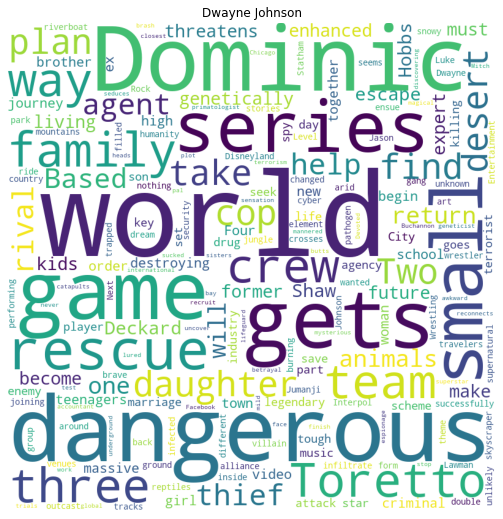

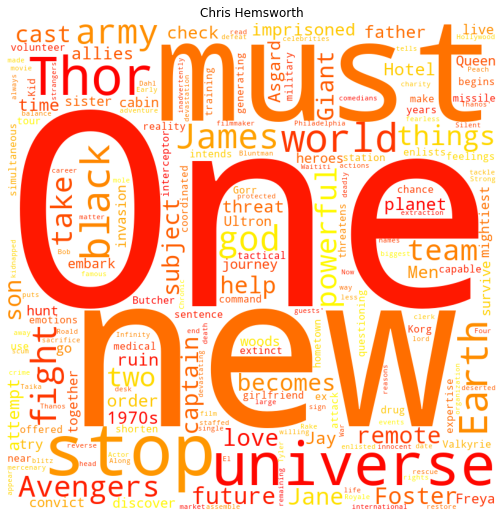

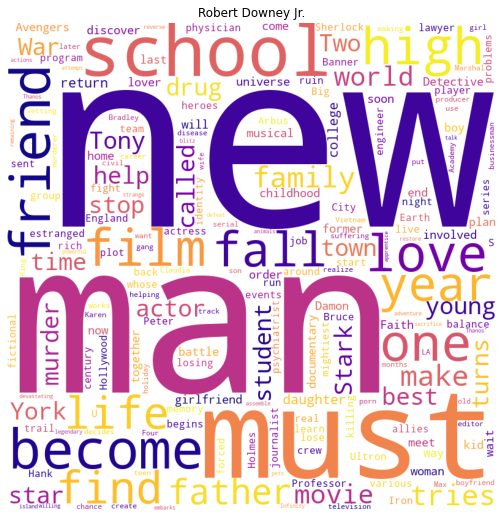

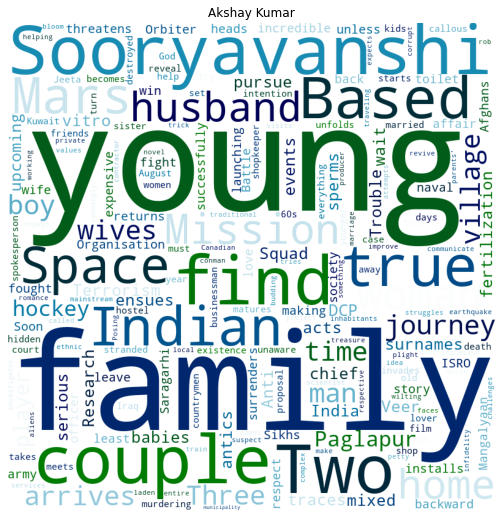

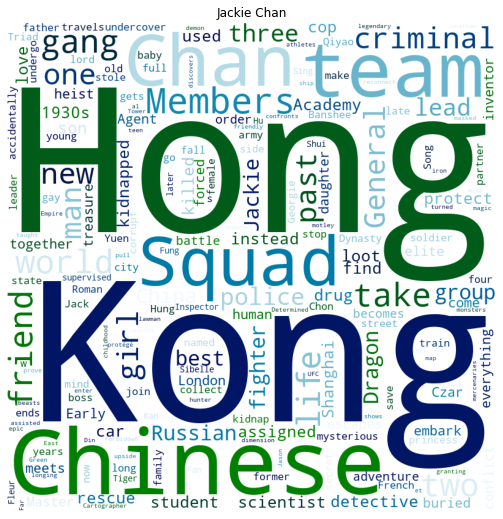

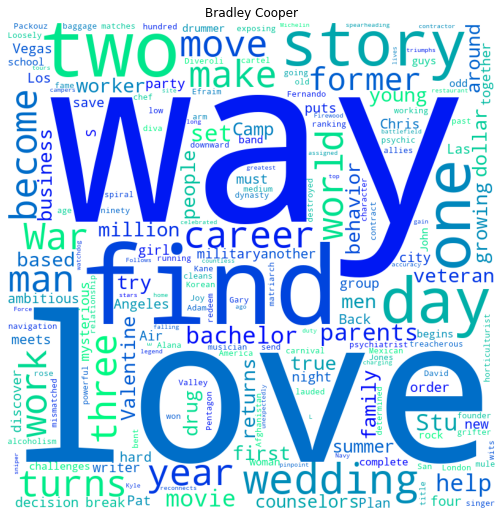

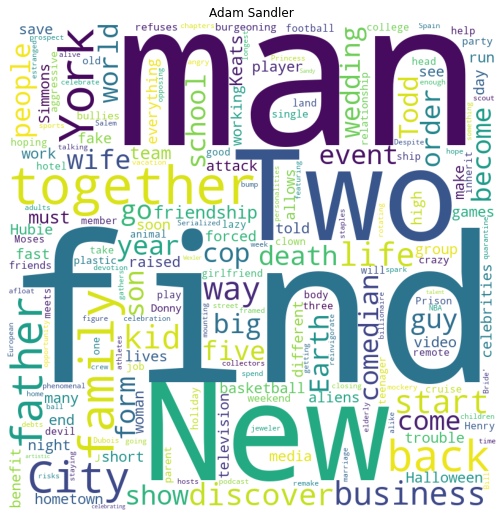

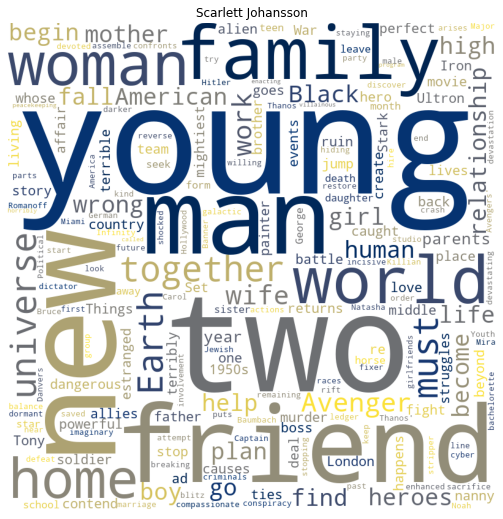

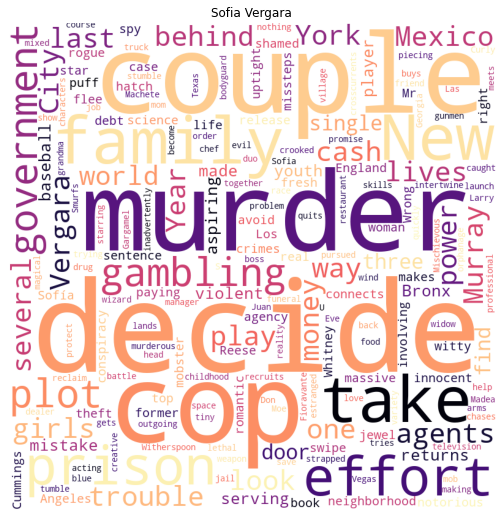

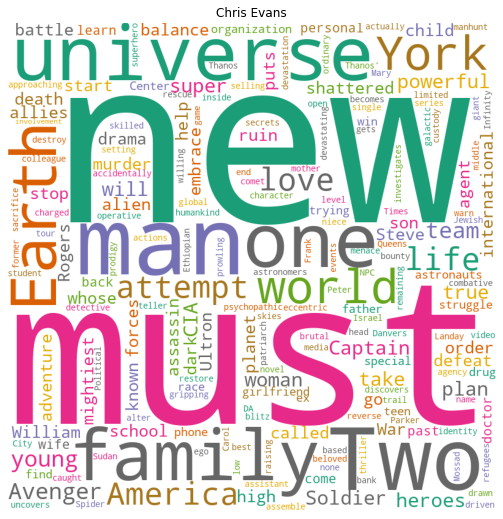

In [77]:
#create word cloud for each actor
for name in names_and_urls.keys():
    file_name = name.replace(' ', '_')
    with open(f'{file_name}.txt') as file:
        text = file.read()

    color = random.choice(['viridis', 'plasma', 'inferno', 'magma', 'cividis', 
                           'winter', 'autumn', 'Dark2', 'ocean', 'gist_earth'])
    word_cloud = WordCloud(
        width=800,
        height=800,
        random_state=1,
        background_color="white",
        colormap=color,
        collocations=False,
        stopwords=STOPWORDS,
        ).generate(text)
    plt.figure(figsize = (16,9))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.title(name)
    plt.show()